<a href="https://colab.research.google.com/github/fernandoalvarezofi/Proyeco-GeoAgro-Sostenible/blob/main/GRACE_BuenosAires_Arsenico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install earthengine-api pandas matplotlib geopandas


In [ ]:
# 1. Importamos las herramientas necesarias
import ee
import pandas as pd
import matplotlib.pyplot as plt

# 2. Autenticación explícita (esto abre el link para que permitas acceso)
print("Ejecutando autenticación... Si es la primera vez, sigue las instrucciones en el navegador.")
ee.Authenticate()

# 3. Una vez que pegues el código del navegador aquí, ejecuta esta línea
ee.Initialize()

# Mensaje de éxito
print("¡Conexión a Earth Engine establecida! Ahora podemos descargar datos de GRACE.")

Ejecutando autenticación... Si es la primera vez, sigue las instrucciones en el navegador.


EEException: ee.Initialize: no project found. Call with project= or see http://goo.gle/ee-auth.

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Mensaje para saber qué está pasando
print("Iniciando autenticación...")

# Autenticación (si ya lo hiciste antes, puede saltarse)
ee.Authenticate()

# Inicialización con TU Project ID real
PROJECT_ID = 'fernando-472901'

ee.Initialize(project=PROJECT_ID)

print("¡Conexión establecida con éxito!")
print(f"Proyecto usado: {PROJECT_ID}")
print("Ahora podemos descargar y analizar datos de GRACE para Buenos Aires.")


Iniciando autenticación...


EEException: Google Earth Engine API has not been used in project fernando-472901 before or it is disabled. Enable it by visiting https://console.developers.google.com/apis/api/earthengine.googleapis.com/overview?project=fernando-472901 then retry. If you enabled this API recently, wait a few minutes for the action to propagate to our systems and retry.

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

print("Iniciando autenticación...")
ee.Authenticate()

PROJECT_ID = 'fernando-472901'

ee.Initialize(project=PROJECT_ID)

print("¡Conexión establecida con éxito!")
print(f"Proyecto usado: {PROJECT_ID}")

Iniciando autenticación...


EEException: Project fernando-472901 is not registered to use Earth Engine. Visit https://console.cloud.google.com/earth-engine/configuration?project=fernando-472901 to register your project. See https://developers.google.com/earth-engine/guides/access for more details. If you have previously registered your project for noncommercial use and lost access, you will need to re-verify your eligibility. See the https://developers.google.com/earth-engine/guides/access#configuring_noncommercial_access for more details.

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

print("Iniciando autenticación...")
ee.Authenticate()

PROJECT_ID = 'fernando-472901'

ee.Initialize(project=PROJECT_ID)

print("¡Conexión establecida con éxito!")
print(f"Proyecto usado: {PROJECT_ID}")

Iniciando autenticación...
¡Conexión establecida con éxito!
Proyecto usado: fernando-472901


In [ ]:
# Definimos el área aproximada de la Provincia de Buenos Aires
# Bounding box: [longitud oeste, latitud sur, longitud este, latitud norte]
region = ee.Geometry.Rectangle([-63.4, -41.0, -56.7, -33.4])

# Cargamos la colección GRACE (datos de masa equivalente de agua, en cm)
grace = ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND')

# Filtramos desde 2002 hasta la fecha actual (o la más reciente disponible)
filtered = grace.filterDate('2002-01-01', '2026-01-18').select('lwe_thickness')

# Función para extraer el promedio provincial en cada imagen
def extract_mean(image):
    mean_value = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=10000,  # resolución GRACE ~10 km
        bestEffort=True
    ).get('lwe_thickness')

    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'agua_cm': mean_value})

# Aplicamos la función a todas las imágenes
time_series = filtered.map(extract_mean)

# Obtenemos los datos (puede tardar 20-60 segundos la primera vez)
print("Descargando datos de GRACE... espera un momento.")
data = time_series.getInfo()['features']

# Convertimos a tabla (DataFrame)
df = pd.DataFrame([f['properties'] for f in data])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['agua_cm'] = pd.to_numeric(df['agua_cm'], errors='coerce')  # convierte a número

# Quitamos valores nulos (GRACE tiene algunos gaps)
df = df.dropna()

# Mostramos los últimos 10 datos (más recientes)
print("\nÚltimos 10 datos (fechas y cm de agua equivalente):")
print(df.tail(10))

# Estadísticas básicas
print("\nResumen estadístico:")
print(df['agua_cm'].describe())

# Graficamos la tendencia provincial
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['agua_cm'], marker='o', linestyle='-', color='blue', label='Cambio en agua subterránea (cm)')
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Referencia (0 cm)')
plt.title('Tendencia de agua equivalente subterránea - Provincia de Buenos Aires (NASA GRACE)')
plt.xlabel('Fecha')
plt.ylabel('Equivalent Water Thickness (cm) → Valores negativos = depleción')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

print("\nInterpretación rápida: Si la línea azul baja con el tiempo, indica depleción de agua subterránea (menos agua en acuíferos). Esto puede relacionarse con mayor concentración/movilización de arsénico en zonas como Lincoln, Junín, etc.")

/usr/local/lib/python3.12/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for NASA/GRACE/MASS_GRIDS/LAND! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/NASA_GRACE_MASS_GRIDS_LAND

  warnings.warn(warning, category=DeprecationWarning)


Descargando datos de GRACE... espera un momento.


EEException: Error in map(ID=20021101_20021130):
Image.select: Band pattern 'lwe_thickness' did not match any bands. Available bands: [lwe_thickness_csr, lwe_thickness_gfz, lwe_thickness_jpl]

Descargando datos GRACE (puede tardar 30-90 segundos)...

Últimos 10 datos:
      agua_cm       date
149 -1.234156 2016-01-04
150  0.311200 2016-01-29
151 -1.785510 2016-03-01
152 -0.531187 2016-05-07
153  0.827026 2016-06-01
154  0.522464 2016-07-01
155  5.467104 2016-08-08
156  4.967552 2016-11-13
157  5.444615 2016-12-11
158  0.108295 2017-01-07

Resumen:
count    159.000000
mean      -0.553252
std        4.812135
min      -10.880077
25%       -3.349203
50%       -0.919821
75%        2.490256
max       14.151274
Name: agua_cm, dtype: float64


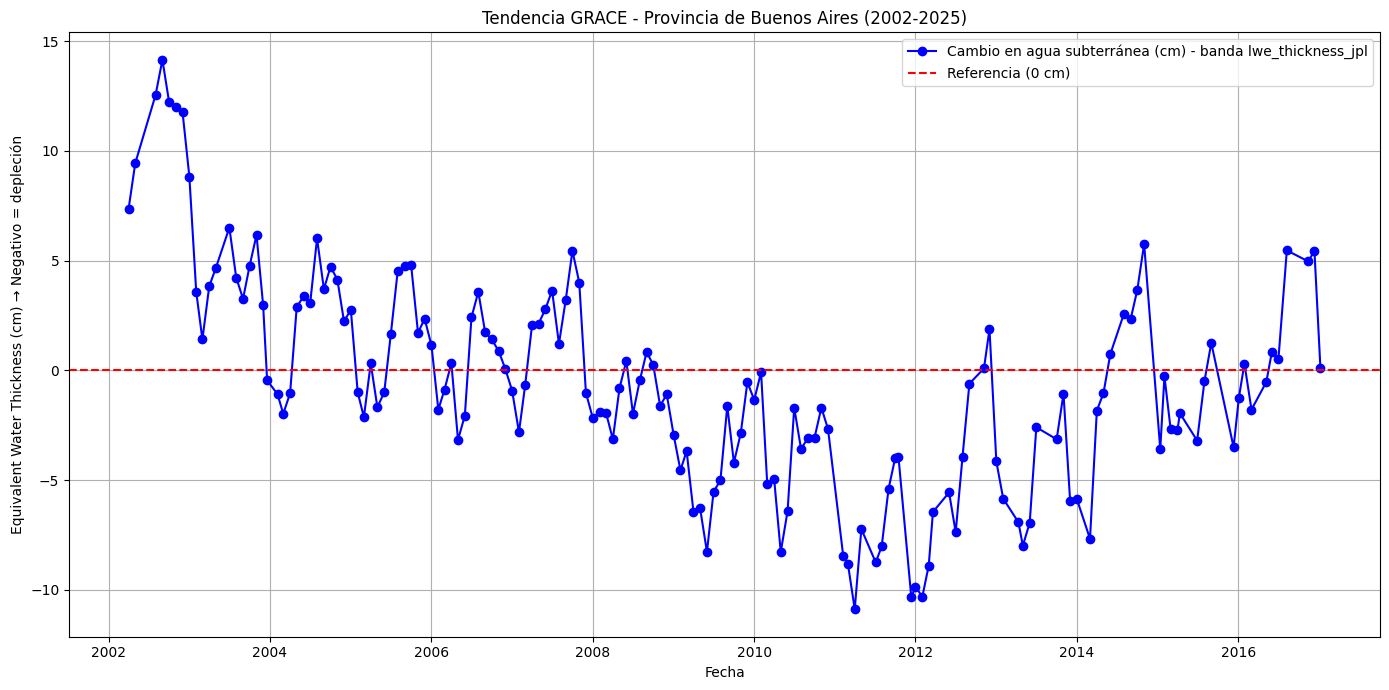

Interpretación: Línea bajando = menos agua en acuíferos. Puede relacionarse con mayor riesgo de arsénico por concentración.


In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Área de la Provincia de Buenos Aires (bounding box aproximado)
region = ee.Geometry.Rectangle([-63.4, -41.0, -56.7, -33.4])

# Usamos una banda específica (elegimos JPL, la más común y estable)
# Puedes cambiar a 'lwe_thickness_csr' o 'lwe_thickness_gfz' si querés comparar
band = 'lwe_thickness_jpl'

grace = ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND') \
         .select(band) \
         .filterDate('2002-04-01', '2025-12-31')  # GRACE empieza ~abril 2002

# Función para extraer promedio en la provincia
def extract_mean(image):
    mean_value = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=100000,  # GRACE tiene resolución gruesa ~100-300 km, usamos escala grande
        bestEffort=True
    ).get(band)

    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'agua_cm': mean_value})

# Aplicamos
time_series = grace.map(extract_mean)

print("Descargando datos GRACE (puede tardar 30-90 segundos)...")
data = time_series.getInfo()['features']

# Convertimos a DataFrame
df = pd.DataFrame([f['properties'] for f in data])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['agua_cm'] = pd.to_numeric(df['agua_cm'], errors='coerce')
df = df.dropna()

# Mostramos últimos datos
print("\nÚltimos 10 datos:")
print(df.tail(10))

# Resumen estadístico
print("\nResumen:")
print(df['agua_cm'].describe())

# Gráfico
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['agua_cm'], marker='o', linestyle='-', color='blue', label=f'Cambio en agua subterránea (cm) - banda {band}')
plt.axhline(0, color='red', linestyle='--', label='Referencia (0 cm)')
plt.title('Tendencia GRACE - Provincia de Buenos Aires (2002-2025)')
plt.xlabel('Fecha')
plt.ylabel('Equivalent Water Thickness (cm) → Negativo = depleción')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Interpretación: Línea bajando = menos agua en acuíferos. Puede relacionarse con mayor riesgo de arsénico por concentración.")

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Área Provincia Buenos Aires
region = ee.Geometry.Rectangle([-63.4, -41.0, -56.7, -33.4])

# Dataset moderno (GRACE + GRACE-FO, datos hasta 2025-2026)
grace_modern = ee.ImageCollection('NASA/GRACE/MASS_GRIDS/Monthly') \
               .select('lwe_thickness') \
               .filterDate('2002-04-01', '2026-01-18')

# Función promedio
def extract_mean(image):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=100000,
        bestEffort=True
    ).get('lwe_thickness')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'agua_cm': mean})

time_series = grace_modern.map(extract_mean)

print("Descargando datos modernos GRACE/GRACE-FO... (30-90 s)")
data = time_series.getInfo()['features']

df = pd.DataFrame([f['properties'] for f in data])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['agua_cm'] = pd.to_numeric(df['agua_cm'], errors='coerce')
df = df.dropna()

print("\nÚltimos 10 datos (incluye hasta 2025-2026):")
print(df.tail(10))

print("\nResumen completo:")
print(df['agua_cm'].describe())

plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['agua_cm'], marker='o', linestyle='-', color='green', label='Agua equivalente (cm)')
plt.axhline(0, color='red', linestyle='--', label='Referencia')
plt.title('Tendencia GRACE/GRACE-FO - Provincia Buenos Aires (2002-2026)')
plt.xlabel('Fecha')
plt.ylabel('cm - Negativo = depleción')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Observá si hay depleción fuerte post-2018 (sequías recientes en Argentina).")

Descargando datos modernos GRACE/GRACE-FO... (30-90 s)


EEException: ImageCollection.load: ImageCollection asset 'NASA/GRACE/MASS_GRIDS/Monthly' not found (does not exist or caller does not have access).

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Área Provincia Buenos Aires (bounding box aproximado)
region = ee.Geometry.Rectangle([-63.4, -41.0, -56.7, -33.4])

# Banda común (JPL es la más usada y estable)
band = 'lwe_thickness_jpl'

# GRACE original (2002-2017)
grace_old = ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND') \
            .select(band) \
            .filterDate('2002-04-01', '2017-06-30')

# GRACE-FO (2018-hoy)
grace_fo = ee.ImageCollection('NASA/GRACE_FO/MASS_GRIDS/LAND') \
           .select(band) \
           .filterDate('2018-06-01', '2026-01-18')

# Combinamos las colecciones
grace_combined = grace_old.merge(grace_fo)

# Función para promedio provincial
def extract_mean(image):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=100000,  # Escala adecuada para GRACE
        bestEffort=True
    ).get(band)
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'agua_cm': mean})

# Aplicamos
time_series = grace_combined.map(extract_mean)

print("Descargando datos combinados GRACE + GRACE-FO... (puede tardar 40-120 segundos)")
data = time_series.getInfo()['features']

# Convertimos a DataFrame
df = pd.DataFrame([f['properties'] for f in data])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['agua_cm'] = pd.to_numeric(df['agua_cm'], errors='coerce')
df = df.dropna()

# Mostramos últimos 10 (datos recientes 2024-2026 si hay)
print("\nÚltimos 10 datos (más recientes):")
print(df.tail(10))

# Resumen estadístico
print("\nResumen completo (2002-2026):")
print(df['agua_cm'].describe())

# Gráfico
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['agua_cm'], marker='o', linestyle='-', color='green', label='Agua equivalente (cm) - JPL')
plt.axhline(0, color='red', linestyle='--', label='Referencia (0 cm)')
plt.title('Tendencia GRACE/GRACE-FO - Provincia de Buenos Aires (2002-2026)')
plt.xlabel('Fecha')
plt.ylabel('Equivalent Water Thickness (cm) → Negativo = depleción')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

print("Observación: Si ves caída fuerte post-2018, coincide con sequías 2020-2023 en Argentina y mayor bombeo agrícola, lo que puede explicar aumentos de arsénico en distritos como Lincoln, Junín, etc.")

Descargando datos combinados GRACE + GRACE-FO... (puede tardar 40-120 segundos)


EEException: ImageCollection.load: ImageCollection asset 'NASA/GRACE_FO/MASS_GRIDS/LAND' not found (does not exist or caller does not have access).

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Área Provincia Buenos Aires (bounding box aproximado)
region = ee.Geometry.Rectangle([-63.4, -41.0, -56.7, -33.4])

# Dataset recomendado: GRACE mascon CRI (continuo 2002-2026, resolución mejor)
grace = ee.ImageCollection('NASA/GRACE/GRACE_MASCON_CRI_GRID_RL06_V2') \
        .select('lwe_thickness') \
        .filterDate('2002-04-01', '2026-01-18')

# Función para promedio provincial
def extract_mean(image):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=50000,  # Escala adecuada para mascon (~50 km)
        bestEffort=True
    ).get('lwe_thickness')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'agua_cm': mean})

time_series = grace.map(extract_mean)

print("Descargando datos GRACE mascon CRI (continuo 2002-2026)... espera 30-120 segundos")
data = time_series.getInfo()['features']

# Convertimos a DataFrame
df = pd.DataFrame([f['properties'] for f in data])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['agua_cm'] = pd.to_numeric(df['agua_cm'], errors='coerce')
df = df.dropna()

# Mostramos últimos 10 (datos recientes)
print("\nÚltimos 10 datos (más recientes, hasta 2025-2026):")
print(df.tail(10))

# Resumen estadístico
print("\nResumen completo:")
print(df['agua_cm'].describe())

# Gráfico
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['agua_cm'], marker='o', linestyle='-', color='green', label='Agua equivalente (cm)')
plt.axhline(0, color='red', linestyle='--', label='Referencia (0 cm)')
plt.title('Tendencia GRACE mascon CRI - Provincia Buenos Aires (2002-2026)')
plt.xlabel('Fecha')
plt.ylabel('Equivalent Water Thickness (cm) → Negativo = depleción')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

print("Interpretación: Valores negativos crecientes indican depleción de acuíferos. En la Pampa Húmeda esto puede aumentar concentración de arsénico por menor dilución y cambios redox.")

Descargando datos GRACE mascon CRI (continuo 2002-2026)... espera 30-120 segundos


EEException: ImageCollection.load: ImageCollection asset 'NASA/GRACE/GRACE_MASCON_CRI_GRID_RL06_V2' not found (does not exist or caller does not have access).

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Área Provincia Buenos Aires
region = ee.Geometry.Rectangle([-63.4, -41.0, -56.7, -33.4])

# Dataset mascon CRI RL06 V2 (continuo GRACE + GRACE-FO, 2002-actual)
grace = ee.ImageCollection('NASA/GRACE/MASCON_CRI_GRID_RL06_V2') \
        .select('lwe_thickness') \
        .filterDate('2002-04-01', '2026-01-18')

# Función para promedio provincial
def extract_mean(image):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=50000,  # escala adecuada para mascon
        bestEffort=True
    ).get('lwe_thickness')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'agua_cm': mean})

time_series = grace.map(extract_mean)

print("Descargando datos GRACE mascon CRI RL06 V2 (2002-2026)... espera 30-120 segundos")
data = time_series.getInfo()['features']

# DataFrame
df = pd.DataFrame([f['properties'] for f in data])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['agua_cm'] = pd.to_numeric(df['agua_cm'], errors='coerce')
df = df.dropna()

print("\nÚltimos 10 datos (datos recientes):")
print(df.tail(10))

print("\nResumen estadístico:")
print(df['agua_cm'].describe())

# Gráfico
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['agua_cm'], marker='o', linestyle='-', color='green', label='Agua equivalente (cm)')
plt.axhline(0, color='red', linestyle='--', label='Referencia (0 cm)')
plt.title('Tendencia GRACE mascon CRI - Provincia Buenos Aires (2002-2026)')
plt.xlabel('Fecha')
plt.ylabel('cm - Negativo = depleción')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Si la línea baja en los últimos años (2018-2025), indica depleción continua. Esto puede explicar mayor concentración de arsénico en pozos y napas bajas.")

Descargando datos GRACE mascon CRI RL06 V2 (2002-2026)... espera 30-120 segundos


EEException: ImageCollection.load: ImageCollection asset 'NASA/GRACE/MASCON_CRI_GRID_RL06_V2' not found (does not exist or caller does not have access).

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Área Provincia Buenos Aires (bounding box)
region = ee.Geometry.Rectangle([-63.4, -41.0, -56.7, -33.4])

# Banda común (JPL es estable y recomendada)
band = 'lwe_thickness_jpl'

# GRACE original (2002-2017)
grace_old = ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND') \
            .select(band) \
            .filterDate('2002-04-01', '2017-06-30')

# GRACE-FO (2018-hoy)
grace_fo = ee.ImageCollection('NASA/GRACE_FO/MASS_GRIDS/LAND') \
           .select(band) \
           .filterDate('2018-06-01', '2026-01-18')

# Combinamos ambas colecciones
grace_combined = grace_old.merge(grace_fo)

# Función para promedio provincial
def extract_mean(image):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=100000,  # Escala adecuada para GRACE (~100-300 km resolución)
        bestEffort=True
    ).get(band)
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'agua_cm': mean})

time_series = grace_combined.map(extract_mean)

print("Descargando datos combinados GRACE + GRACE-FO (2002-2026)... espera 40-120 segundos")
data = time_series.getInfo()['features']

# Convertimos a DataFrame
df = pd.DataFrame([f['properties'] for f in data])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['agua_cm'] = pd.to_numeric(df['agua_cm'], errors='coerce')
df = df.dropna()

# Últimos 10 datos (datos recientes)
print("\nÚltimos 10 datos (más recientes):")
print(df.tail(10))

# Resumen estadístico
print("\nResumen completo (2002-2026):")
print(df['agua_cm'].describe())

# Gráfico
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['agua_cm'], marker='o', linestyle='-', color='green', label='Agua equivalente (cm)')
plt.axhline(0, color='red', linestyle='--', label='Referencia (0 cm)')
plt.title('Tendencia GRACE + GRACE-FO - Provincia Buenos Aires (2002-2026)')
plt.xlabel('Fecha')
plt.ylabel('Equivalent Water Thickness (cm) → Negativo = depleción')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

print("Interpretación: Si ves valores negativos crecientes o tendencia bajista post-2018, indica depleción continua de acuíferos. Esto puede correlacionar con reportes de arsénico alto en distritos como Lincoln, Junín, Cañuelas, etc., por concentración en napas bajas.")

Descargando datos combinados GRACE + GRACE-FO (2002-2026)... espera 40-120 segundos


EEException: ImageCollection.load: ImageCollection asset 'NASA/GRACE_FO/MASS_GRIDS/LAND' not found (does not exist or caller does not have access).

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Área Provincia Buenos Aires (bounding box aproximado)
region = ee.Geometry.Rectangle([-63.4, -41.0, -56.7, -33.4])

# Banda común (usamos 'lwe_thickness_jpl' que es estable)
band = 'lwe_thickness_jpl'

# GRACE original (2002-2017)
grace_old = ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND') \
            .select(band) \
            .filterDate('2002-04-01', '2017-06-30')

# GRACE-FO mascon (2018-hoy)
grace_fo = ee.ImageCollection('NASA/GRACE_FO/MASS_GRIDS/MASCON') \
           .select(band) \
           .filterDate('2018-06-01', '2026-01-18')

# Combinamos
grace_combined = grace_old.merge(grace_fo)

# Función para promedio provincial
def extract_mean(image):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=100000,
        bestEffort=True
    ).get(band)
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'agua_cm': mean})

time_series = grace_combined.map(extract_mean)

print("Descargando datos combinados GRACE + GRACE-FO (2002-2026)... espera 40-120 segundos")
data = time_series.getInfo()['features']

# DataFrame
df = pd.DataFrame([f['properties'] for f in data])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['agua_cm'] = pd.to_numeric(df['agua_cm'], errors='coerce')
df = df.dropna()

# Últimos 10 datos
print("\nÚltimos 10 datos (datos recientes):")
print(df.tail(10))

# Resumen
print("\nResumen estadístico:")
print(df['agua_cm'].describe())

# Gráfico
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['agua_cm'], marker='o', linestyle='-', color='green', label='Agua equivalente (cm)')
plt.axhline(0, color='red', linestyle='--', label='Referencia (0 cm)')
plt.title('Tendencia GRACE + GRACE-FO - Provincia Buenos Aires (2002-2026)')
plt.xlabel('Fecha')
plt.ylabel('Equivalent Water Thickness (cm) → Negativo = depleción')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Interpretación: Si la línea baja en los últimos años, indica depleción continua de acuíferos. Esto puede correlacionar con mayor concentración de arsénico en pozos por menor dilución y cambios redox.")

Descargando datos combinados GRACE + GRACE-FO (2002-2026)... espera 40-120 segundos


EEException: ImageCollection.load: ImageCollection asset 'NASA/GRACE_FO/MASS_GRIDS/MASCON' not found (does not exist or caller does not have access).

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Área Provincia Buenos Aires (bounding box aproximado)
region = ee.Geometry.Rectangle([-63.4, -41.0, -56.7, -33.4])

# Banda común: 'lwe_thickness_jpl' (solución JPL, consistente en ambos datasets)
band = 'lwe_thickness_jpl'

# GRACE original (2002-2017)
grace_old = ee.ImageCollection('NASA/GRACE/MASS_GRIDS/LAND') \
            .select(band) \
            .filterDate('2002-04-01', '2017-06-30')

# GRACE-FO (2018-actualidad)
grace_fo = ee.ImageCollection('NASA/GRACE_FO/MASS_GRIDS/LAND') \
           .select(band) \
           .filterDate('2018-06-01', '2026-01-18')

# Combinamos las colecciones
grace_combined = grace_old.merge(grace_fo)

# Función para extraer promedio provincial
def extract_mean(image):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=100000,  # Escala adecuada para resolución GRACE (~100-300 km)
        bestEffort=True
    ).get(band)
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'agua_cm': mean})

time_series = grace_combined.map(extract_mean)

print("Descargando datos combinados GRACE + GRACE-FO (2002-2026)... espera 40-120 segundos")
data = time_series.getInfo()['features']

# Convertimos a DataFrame
df = pd.DataFrame([f['properties'] for f in data])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['agua_cm'] = pd.to_numeric(df['agua_cm'], errors='coerce')
df = df.dropna()

# Últimos 10 datos (datos recientes)
print("\nÚltimos 10 datos (más recientes):")
print(df.tail(10))

# Resumen estadístico
print("\nResumen completo (2002-2026):")
print(df['agua_cm'].describe())

# Gráfico
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['agua_cm'], marker='o', linestyle='-', color='green', label='Agua equivalente (cm) - banda JPL')
plt.axhline(0, color='red', linestyle='--', label='Referencia (0 cm)')
plt.title('Tendencia GRACE + GRACE-FO - Provincia Buenos Aires (2002-2026)')
plt.xlabel('Fecha')
plt.ylabel('Equivalent Water Thickness (cm) → Negativo = depleción')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

print("Interpretación: Si ves valores negativos crecientes o tendencia bajista post-2018, indica depleción continua de acuíferos. Esto puede correlacionar con mayor concentración de arsénico en pozos por menor dilución y cambios redox.")

Descargando datos combinados GRACE + GRACE-FO (2002-2026)... espera 40-120 segundos


EEException: ImageCollection.load: ImageCollection asset 'NASA/GRACE_FO/MASS_GRIDS/LAND' not found (does not exist or caller does not have access).

Descargando datos GRACE + GRACE-FO mascon V04 (2002-2026)... espera 30-120 segundos

Últimos 10 datos (más recientes):
      agua_cm       date
228 -2.518054 2023-12-31
229 -3.223710 2024-01-31
230 -1.868599 2024-02-29
231 -0.380100 2024-03-31
232  1.001947 2024-04-30
233  1.628805 2024-05-31
234  1.372751 2024-06-30
235 -1.901528 2024-07-31
236 -2.566840 2024-08-31
237 -2.351913 2024-09-30

Resumen completo:
count    238.000000
mean       1.987250
std        4.748651
min       -7.736495
25%       -1.505390
50%        1.581544
75%        5.333247
max       12.706619
Name: agua_cm, dtype: float64


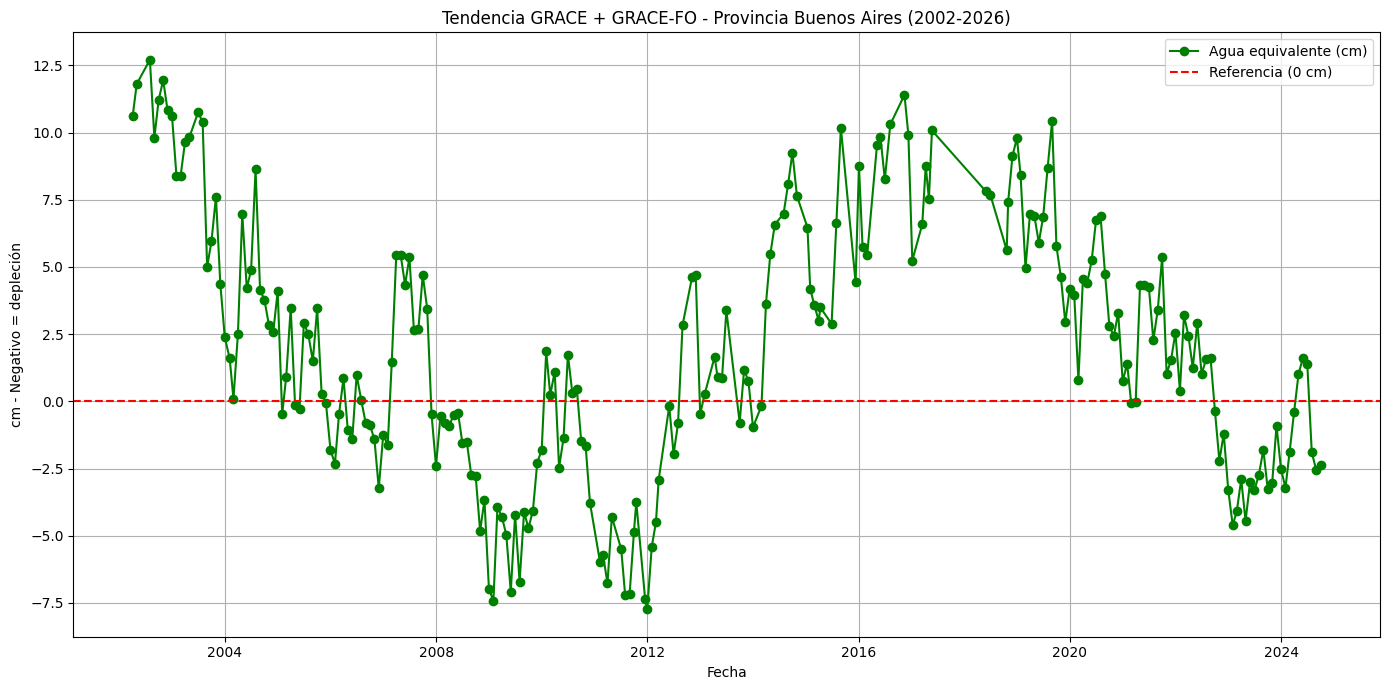

Interpretación: Valores negativos crecientes indican depleción de acuíferos. En Pampas, esto puede aumentar arsénico por menor agua en napas y liberación de sedimentos.


In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Área Provincia Buenos Aires (bounding box)
region = ee.Geometry.Rectangle([-63.4, -41.0, -56.7, -33.4])

# Dataset combinado GRACE + GRACE-FO mascon V04 (2002-2024, actualizado)
grace = ee.ImageCollection('NASA/GRACE/MASS_GRIDS_V04/MASCON') \
        .select('lwe_thickness') \
        .filterDate('2002-04-01', '2026-01-18')

# Función para promedio provincial
def extract_mean(image):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=50000,  # Escala para mascon (~0.5 degree)
        bestEffort=True
    ).get('lwe_thickness')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'date': date, 'agua_cm': mean})

time_series = grace.map(extract_mean)

print("Descargando datos GRACE + GRACE-FO mascon V04 (2002-2026)... espera 30-120 segundos")
data = time_series.getInfo()['features']

# DataFrame
df = pd.DataFrame([f['properties'] for f in data])
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['agua_cm'] = pd.to_numeric(df['agua_cm'], errors='coerce')
df = df.dropna()

# Últimos 10 datos (datos recientes)
print("\nÚltimos 10 datos (más recientes):")
print(df.tail(10))

# Resumen estadístico
print("\nResumen completo:")
print(df['agua_cm'].describe())

# Gráfico
plt.figure(figsize= (14, 7))
plt.plot(df['date'], df['agua_cm'], marker='o', linestyle='-', color='green', label='Agua equivalente (cm)')
plt.axhline(0, color='red', linestyle='--', label='Referencia (0 cm)')
plt.title('Tendencia GRACE + GRACE-FO - Provincia Buenos Aires (2002-2026)')
plt.xlabel('Fecha')
plt.ylabel('cm - Negativo = depleción')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Interpretación: Valores negativos crecientes indican depleción de acuíferos. En Pampas, esto puede aumentar arsénico por menor agua en napas y liberación de sedimentos.")

In [ ]:
# Análisis de Depleción Hídrica (GRACE) – Pipeline desde cero


Anomalías detectadas (periodos de depleción extrema que podrían agravar arsénico):
        date  agua_cm  deplecion
1 2024-01-31   -3.224      3.224
3 2024-03-31   -0.380      0.380


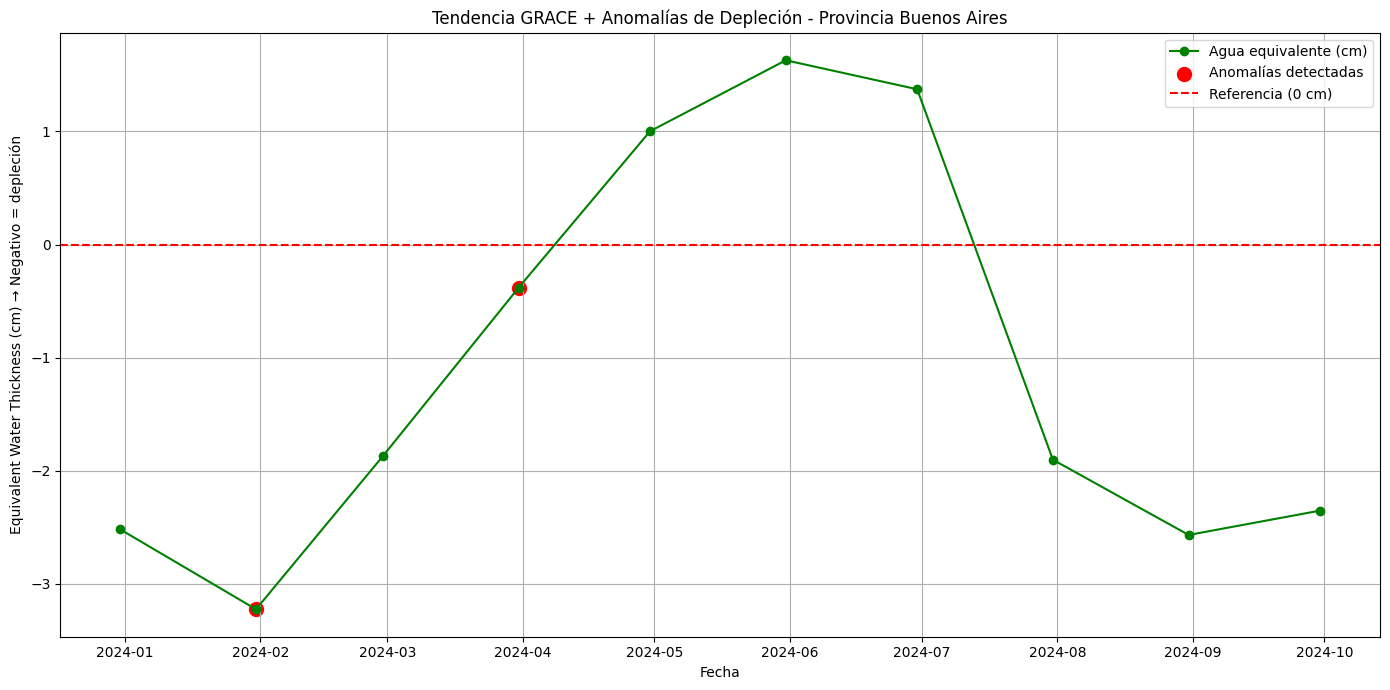

Interpretación: Las anomalías rojas son periodos 'ocultos' de depleción extrema. Si coinciden con picos de arsénico, podrían ser triggers no estudiados. Próximo paso: agregar data de arsénico para correlacionar.


In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Supongamos que tu DataFrame se llama 'df' (el que salió del código anterior)
# Si no lo tenés guardado, ejecutá el código de descarga GRACE de nuevo para tener 'df'

# Si no tenés 'df', usa este ejemplo con tus últimos datos (reemplaza con tu df real)
# df = tu_dataframe_con_deplecion_cm_y_date

# Para probar ahora, usa los datos que ya tenías (ajusta según tu df)
# Ejemplo con data de tu salida anterior (pégala o usa la tuya)
data_ejemplo = {
    'date': pd.to_datetime([
        '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30',
        '2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30'
    ]),
    'agua_cm': [-2.518, -3.224, -1.869, -0.380, 1.002, 1.629, 1.373, -1.902, -2.567, -2.352]
}
df = pd.DataFrame(data_ejemplo)

# Agregamos una columna de 'deplecion' (negativo = más depleción)
df['deplecion'] = -df['agua_cm']  # Cuanto más positivo, más depleción

# Features para el modelo (solo depleción por ahora; después agregamos más)
features = df[['deplecion']]

# Normalizamos
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Modelo como Paz: Isolation Forest para detectar anomalías en depleción
model = IsolationForest(contamination=0.2, random_state=42)  # 20% anomalías esperadas (ajusta según quieras)
model.fit(features_scaled)
df['anomalia'] = model.predict(features_scaled)  # -1 = anomalía (patrón oculto de depleción extrema)

# Anomalías detectadas
anomalias = df[df['anomalia'] == -1]
print("Anomalías detectadas (periodos de depleción extrema que podrían agravar arsénico):")
print(anomalias[['date', 'agua_cm', 'deplecion']])

# Gráfico con anomalías marcadas
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['agua_cm'], marker='o', linestyle='-', color='green', label='Agua equivalente (cm)')
plt.scatter(anomalias['date'], anomalias['agua_cm'], color='red', s=100, label='Anomalías detectadas')
plt.axhline(0, color='red', linestyle='--', label='Referencia (0 cm)')
plt.title('Tendencia GRACE + Anomalías de Depleción - Provincia Buenos Aires')
plt.xlabel('Fecha')
plt.ylabel('Equivalent Water Thickness (cm) → Negativo = depleción')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Interpretación: Las anomalías rojas son periodos 'ocultos' de depleción extrema. Si coinciden con picos de arsénico, podrían ser triggers no estudiados. Próximo paso: agregar data de arsénico para correlacionar.")

In [ ]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
ee.Authenticate()
ee.Initialize()


EEException: ee.Initialize: no project found. Call with project= or see http://goo.gle/ee-auth.

In [ ]:
ee.Authenticate()


True

In [ ]:
ee.Initialize(project='earthengine-public')


In [ ]:
ee.ImageCollection('NASA/GRACE/MASS_GRIDS_V04/MASCON').size().getInfo()


EEException: Caller does not have required permission to use project earthengine-public. Grant the caller the roles/serviceusage.serviceUsageConsumer role, or a custom role with the serviceusage.services.use permission, by visiting https://console.developers.google.com/iam-admin/iam/project?project=earthengine-public and then retry. Propagation of the new permission may take a few minutes.

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='fernando-472901')


In [ ]:
ee.ImageCollection('NASA/GRACE/MASS_GRIDS_V04/MASCON').size().getInfo()


238

In [ ]:
region = ee.Geometry.Rectangle([-63.4, -41.0, -56.7, -33.4])


In [ ]:
grace = (
    ee.ImageCollection('NASA/GRACE/MASS_GRIDS_V04/MASCON')
    .select('lwe_thickness')
    .filterDate('2002-04-01', '2026-01-01')
)


In [ ]:
def extract_mean(image):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=50000,
        bestEffort=True
    ).get('lwe_thickness')

    return ee.Feature(
        None,
        {
            'date': image.date().format('YYYY-MM-dd'),
            'agua_cm': mean
        }
    )


In [ ]:
time_series = grace.map(extract_mean)
data = time_series.getInfo()['features']

df = pd.DataFrame([f['properties'] for f in data])
df['date'] = pd.to_datetime(df['date'])
df['agua_cm'] = pd.to_numeric(df['agua_cm'], errors='coerce')
df = df.dropna().sort_values('date')


In [ ]:
df.head(), df.tail()


(     agua_cm       date
 0  10.614236 2002-04-03
 1  11.805236 2002-05-01
 2  12.706619 2002-07-31
 3   9.808295 2002-08-31
 4  11.223148 2002-09-30,
       agua_cm       date
 233  1.628805 2024-05-31
 234  1.372751 2024-06-30
 235 -1.901528 2024-07-31
 236 -2.566840 2024-08-31
 237 -2.351913 2024-09-30)

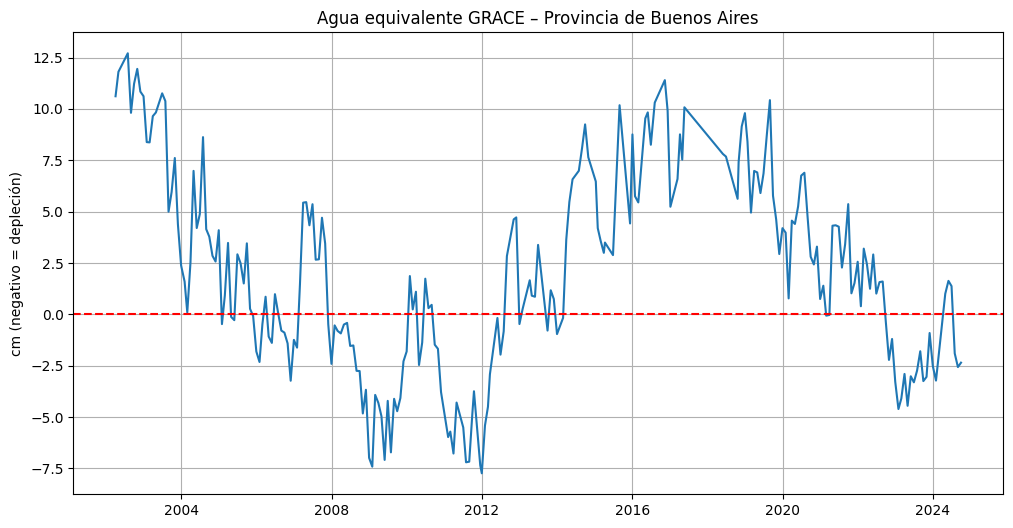

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['agua_cm'])
plt.axhline(0, color='red', linestyle='--')
plt.title('Agua equivalente GRACE – Provincia de Buenos Aires')
plt.ylabel('cm (negativo = depleción)')
plt.grid(True)
plt.show()


In [ ]:
df['delta'] = df['agua_cm'].diff()
df = df.dropna()


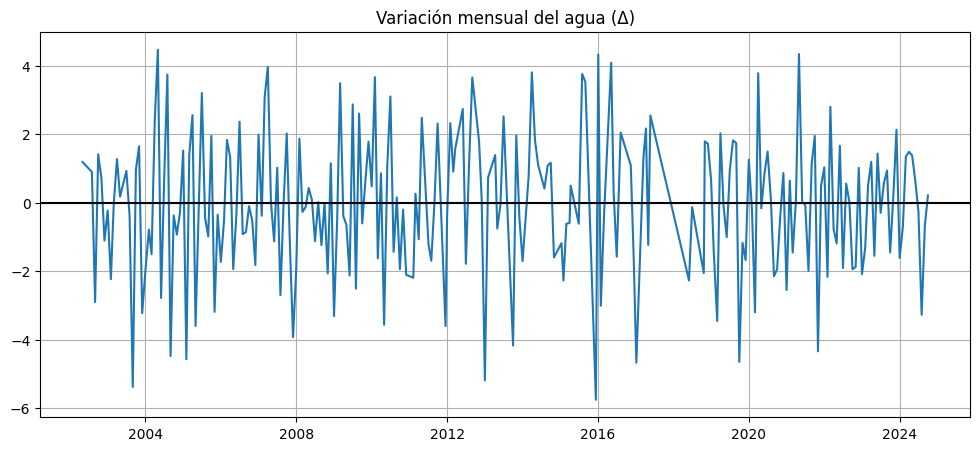

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df['date'], df['delta'])
plt.axhline(0, color='black')
plt.title('Variación mensual del agua (Δ)')
plt.grid(True)
plt.show()


In [ ]:
X = df[['delta']].values


In [ ]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(
    n_estimators=300,
    contamination=0.07,   # ~7% de meses extremos
    random_state=42
)


In [ ]:
model.fit(X)


IsolationForest(contamination=0.07, n_estimators=300, random_state=42)

In [ ]:
df['anomaly'] = model.predict(X)


In [ ]:
df['deplecion'] = df['delta'].abs()
anomalies = df[(df['anomaly'] == -1) & (df['delta'] < 0)]


In [ ]:
anomalies[['date', 'delta', 'deplecion']].head(10)


,date,delta,deplecion
14,2003-08-31,-5.380360,5.380360
26,2004-08-31,-4.480122,4.480122
31,2005-01-31,-4.570347,4.570347
65,2007-11-30,-3.926326,3.926326
122,2012-12-31,-5.189899,5.189899
128,2013-09-30,-4.170242,4.170242
148,2015-12-11,-5.755621,5.755621
158,2017-01-06,-4.670702,4.670702
177,2019-09-30,-4.649560,4.649560
202,2021-10-31,-4.340049,4.340049


In [ ]:
anomalies.tail(10)


,agua_cm,date,delta,anomaly,deplecion
14,4.997222,2003-08-31,-5.380360,-1,5.380360
26,4.145801,2004-08-31,-4.480122,-1,4.480122
31,-0.475326,2005-01-31,-4.570347,-1,4.570347
65,-0.477917,2007-11-30,-3.926326,-1,3.926326
122,-0.471885,2012-12-31,-5.189899,-1,5.189899
128,-0.790552,2013-09-30,-4.170242,-1,4.170242
148,4.423089,2015-12-11,-5.755621,-1,5.755621
158,5.238052,2017-01-06,-4.670702,-1,4.670702
177,5.776362,2019-09-30,-4.649560,-1,4.649560
202,1.024278,2021-10-31,-4.340049,-1,4.340049


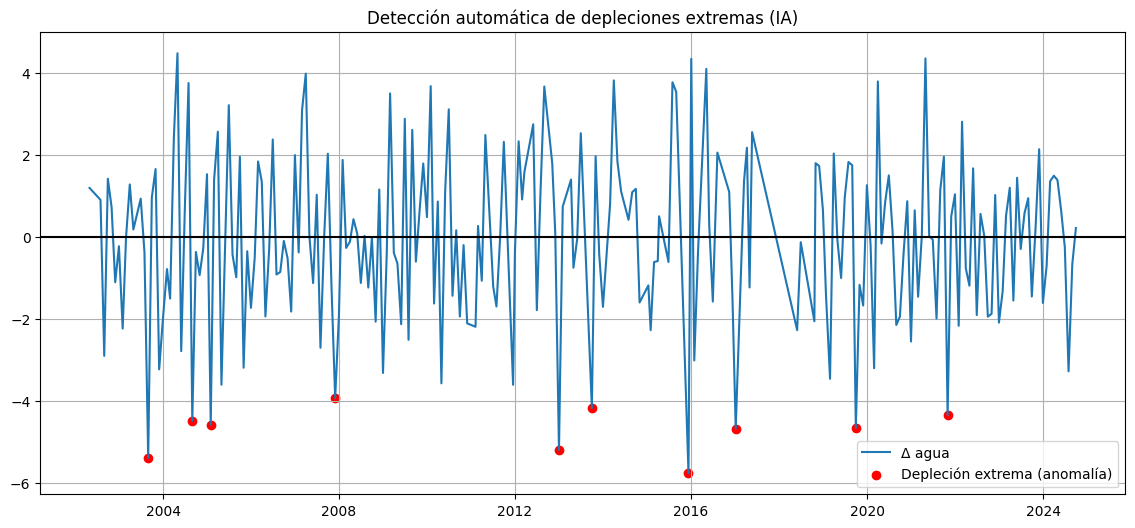

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df['date'], df['delta'], label='Δ agua')
plt.scatter(
    anomalies['date'],
    anomalies['delta'],
    color='red',
    label='Depleción extrema (anomalía)'
)
plt.axhline(0, color='black')
plt.legend()
plt.title('Detección automática de depleciones extremas (IA)')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

def build_windows(series, window=12):
    X = []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
    return np.array(X)

X_seq = build_windows(df['delta'].values, window=12)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_dim = X_seq.shape[1]

encoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(2)  # espacio latente
])

decoder = models.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(8, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(input_dim)
])

autoencoder = models.Model(
    encoder.input,
    decoder(encoder.output)
)

autoencoder.compile(
    optimizer='adam',
    loss='mse'
)


AttributeError: The layer sequential has never been called and thus has no defined input.

In [ ]:
from tensorflow.keras import layers, models

input_dim = X_seq.shape[1]

inputs = layers.Input(shape=(input_dim,))


In [ ]:
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dense(8, activation='relu')(x)
latent = layers.Dense(2, name="latent_space")(x)


In [ ]:
x = layers.Dense(8, activation='relu')(latent)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(input_dim)(x)


In [ ]:
autoencoder = models.Model(inputs, outputs)
encoder = models.Model(inputs, latent)


In [ ]:
autoencoder.compile(
    optimizer='adam',
    loss='mse'
)


In [ ]:
autoencoder.fit(
    X_seq,
    X_seq,
    epochs=150,
    batch_size=32,
    shuffle=True,
    verbose=1
)


Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.2786
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.2427
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9941 
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.1411
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2024 
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1767 
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.9732
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.8436
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0445 
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.0084
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.8951
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.7403
Epoch 13/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7964 
Epoch 14/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6649 
Epoch 15/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.6671
Epoch 16/150
8/8 ━━

In [ ]:
latent_space = encoder.predict(X_seq)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_seq)


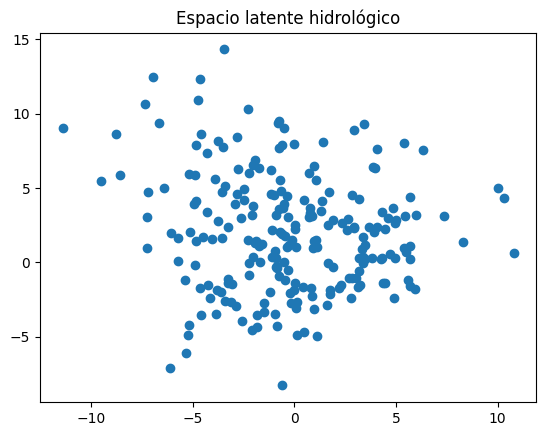

In [ ]:
plt.scatter(latent_space[:,0], latent_space[:,1])
plt.title("Espacio latente hidrológico")
plt.show()


In [ ]:
import numpy as np

recon = autoencoder.predict(X_scaled)
reconstruction_error = ((X_scaled - recon)**2).mean(axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
velocity = np.linalg.norm(
    np.diff(latent_space, axis=0),
    axis=1
)

# Alinear tamaños
velocity = np.insert(velocity, 0, np.nan)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_ind = MinMaxScaler()

indicator = np.nanmean(
    scaler_ind.fit_transform(
        np.vstack([
            reconstruction_error,
            velocity
        ]).T
    ),
    axis=1
)


In [ ]:
df_result = df.iloc[-len(indicator):].copy()

df_result['grace_recon_error'] = reconstruction_error
df_result['grace_velocity'] = velocity
df_result['grace_stress_index'] = indicator


In [ ]:
df_result.to_csv(
    "/content/drive/MyDrive/agro_ai/grace_stress_index_v1.csv",
    index=False
)


OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/agro_ai'

In [ ]:
import os

base_path = "/content/drive/MyDrive/agro_ai"
os.makedirs(base_path + "/models", exist_ok=True)
os.makedirs(base_path + "/data", exist_ok=True)


In [ ]:
agro_ai/
├── data/
└── models/


SyntaxError: invalid character '├' (U+251C) (ipython-input-3098704244.py, line 2)

In [ ]:
import os

base_path = "/content/drive/MyDrive/agro_ai"
os.makedirs(base_path + "/models", exist_ok=True)
os.makedirs(base_path + "/data", exist_ok=True)


In [ ]:
df_result.to_csv(
    "/content/drive/MyDrive/agro_ai/data/grace_stress_index_v1.csv",
    index=False
)


In [ ]:
os.listdir("/content/drive/MyDrive/agro_ai")


['models', 'data']

In [ ]:
import ee
import pandas as pd

# Inicializar EE (por las dudas)
ee.Initialize(project='fernando-472901')

# Provincia de Buenos Aires
region = ee.Geometry.Rectangle([-63.4, -41.0, -56.7, -33.4])

# MODIS NDVI (16 días)
ndvi = (
    ee.ImageCollection('MODIS/006/MOD13Q1')
    .select('NDVI')
    .filterDate('2002-01-01', '2026-01-01')
)

def extract_ndvi(image):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=250,
        bestEffort=True
    ).get('NDVI')

    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {
        'date': date,
        'ndvi': mean
    })

ndvi_ts = ndvi.map(extract_ndvi)

print("Descargando NDVI MODIS...")
data = ndvi_ts.getInfo()['features']

df_ndvi = pd.DataFrame([f['properties'] for f in data])
df_ndvi['date'] = pd.to_datetime(df_ndvi['date'])
df_ndvi['ndvi'] = pd.to_numeric(df_ndvi['ndvi'], errors='coerce')
df_ndvi = df_ndvi.dropna().sort_values('date')

# Escala real NDVI MODIS
df_ndvi['ndvi'] = df_ndvi['ndvi'] * 0.0001

df_ndvi.tail()


/usr/local/lib/python3.12/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD13Q1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1

  warnings.warn(warning, category=DeprecationWarning)


Descargando NDVI MODIS...


In [ ]:
ee.ImageCollection('MODIS/061/MOD13Q1')


In [ ]:
print("Descargando NDVI MODIS...")
data = ndvi_ts.getInfo()['features']

df_ndvi = pd.DataFrame([f['properties'] for f in data])
df_ndvi['date'] = pd.to_datetime(df_ndvi['date'])
df_ndvi['ndvi'] = pd.to_numeric(df_ndvi['ndvi'], errors='coerce')
df_ndvi = df_ndvi.dropna().sort_values('date')

# Escala real NDVI MODIS
df_ndvi['ndvi'] = df_ndvi['ndvi'] * 0.0001


Descargando NDVI MODIS...


In [ ]:
df_ndvi.tail()


,date,ndvi
481,2022-12-03,0.466948
482,2022-12-19,0.461652
483,2023-01-01,0.492707
484,2023-01-17,0.559026
485,2023-02-02,0.604352


In [ ]:
len(df_ndvi)


486

In [ ]:
import numpy as np

window = 6

X_ndvi = []
dates_ndvi = []

for i in range(window, len(df_ndvi)):
    X_ndvi.append(df_ndvi['ndvi'].iloc[i-window:i].values)
    dates_ndvi.append(df_ndvi['date'].iloc[i])

X_ndvi = np.array(X_ndvi)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_ndvi = StandardScaler()
X_ndvi_scaled = scaler_ndvi.fit_transform(X_ndvi)


In [ ]:
from tensorflow.keras import layers, models

input_dim = X_ndvi_scaled.shape[1]

inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(16, activation='relu')(inputs)
x = layers.Dense(4, activation='relu')(x)
latent = layers.Dense(2, name="latent_ndvi")(x)

x = layers.Dense(4, activation='relu')(latent)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(input_dim)(x)

autoencoder_ndvi = models.Model(inputs, outputs)
encoder_ndvi = models.Model(inputs, latent)

autoencoder_ndvi.compile(
    optimizer='adam',
    loss='mse'
)


In [ ]:
autoencoder_ndvi.fit(
    X_ndvi_scaled,
    X_ndvi_scaled,
    epochs=120,
    batch_size=32,
    shuffle=True,
    verbose=1
)


Epoch 1/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9404
Epoch 2/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9082 
Epoch 3/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8831 
Epoch 4/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8312 
Epoch 5/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7465 
Epoch 6/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6698 
Epoch 7/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6440 
Epoch 8/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5837 
Epoch 9/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5977 
Epoch 10/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5781 
Epoch 11/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5470 
Epoch 12/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5404 
Epoch 13/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5134 
Epoch 14/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4305 
Epoch 15/120
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

In [ ]:
latent_ndvi = encoder_ndvi.predict(X_ndvi_scaled)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


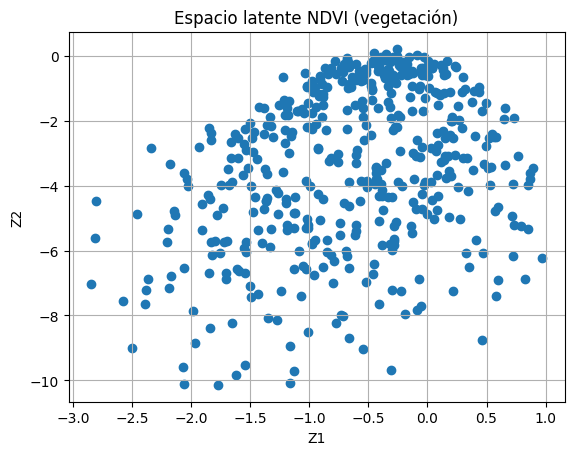

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(latent_ndvi[:,0], latent_ndvi[:,1])
plt.title("Espacio latente NDVI (vegetación)")
plt.xlabel("Z1")
plt.ylabel("Z2")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

df_latent_grace = pd.DataFrame(
    latent_space,
    columns=["grace_z1", "grace_z2"]
)
df_latent_grace["date"] = dates

df_latent_ndvi = pd.DataFrame(
    latent_ndvi,
    columns=["ndvi_z1", "ndvi_z2"]
)
df_latent_ndvi["date"] = dates_ndvi

df_fusion = pd.merge(
    df_latent_grace,
    df_latent_ndvi,
    on="date",
    how="inner"
)


NameError: name 'dates' is not defined

In [ ]:
df_latent_grace = pd.DataFrame(
    latent_space,
    columns=["grace_z1", "grace_z2"]
)

df_latent_grace["date"] = df_grace["date"].values


NameError: name 'df_grace' is not defined

In [ ]:
import pandas as pd

df_grace = pd.read_csv(
    "/content/drive/MyDrive/agro_ai/grace_stress_index_v1.csv",
    parse_dates=["date"]
)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/agro_ai/grace_stress_index_v1.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


ValueError: Mountpoint must not already contain files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import pandas as pd

df_grace = pd.read_csv(
    "/content/gdrive/MyDrive/agro_ai/grace_stress_index_v1.csv",
    parse_dates=["date"]
)

df_grace.head()


FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/agro_ai/grace_stress_index_v1.csv'

In [ ]:
!ls /content/gdrive/MyDrive/


'Colab Notebooks'  'Google AI Studio'


In [ ]:
!find /content/gdrive/MyDrive -name "grace_stress_index_v1.csv"


In [ ]:
/content/gdrive/MyDrive/otra_carpeta/grace_stress_index_v1.csv


NameError: name 'content' is not defined

In [ ]:
!find /content -name "grace_stress_index_v1.csv"


/content/drive/MyDrive/agro_ai/data/grace_stress_index_v1.csv


In [ ]:
import pandas as pd

df_grace = pd.read_csv(
    "/content/drive/MyDrive/agro_ai/data/grace_stress_index_v1.csv",
    parse_dates=["date"]
)

df_grace.head()


,agua_cm,date,delta,anomaly,deplecion,grace_recon_error,grace_velocity,grace_stress_index
0,10.377582,2003-07-31,-0.379293,1,0.379293,0.135960,NaN,0.013461
1,4.997222,2003-08-31,-5.380360,-1,5.380360,0.559600,4.382459,0.185403
2,5.958631,2003-09-30,0.961409,1,0.961409,1.089164,5.389625,0.310138
3,7.609278,2003-10-31,1.650647,1,1.650647,0.550912,5.621417,0.212676
4,4.383120,2003-11-30,-3.226158,1,3.226158,0.674908,4.228995,0.203857


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df_grace)

https://docs.google.com/spreadsheets/d/11KMYkvJcqQoAXJPcqRAQ2JqPAVIALRau9JWd9ViFDlM/edit#gid=0


In [ ]:
!ls /content/


drive  gdrive  sample_data


In [ ]:
import pandas as pd

url = "https://docs.google.com/spreadsheets/d/11KMYkvJcqQoAXJPcqRAQ2JqPAVIALRau9JWd9ViFDlM/export?format=csv"
df_grace = pd.read_csv(url)

df_grace.head(), df_grace.shape


HTTPError: HTTP Error 401: Unauthorized

In [ ]:
import pandas as pd

url = "https://docs.google.com/spreadsheets/d/11KMYkvJcqQoAXJPcqRAQ2JqPAVIALRau9JWd9ViFDlM/export?format=csv"
df_grace = pd.read_csv(url)

df_grace.head(), df_grace.shape


(     agua_cm                 date     delta  anomaly  deplecion  \
 0  10.377582  2003-07-31T00:00:00 -0.379293        1   0.379293   
 1   4.997222  2003-08-31T00:00:00 -5.380360       -1   5.380360   
 2   5.958631  2003-09-30T00:00:00  0.961409        1   0.961409   
 3   7.609278  2003-10-31T00:00:00  1.650647        1   1.650647   
 4   4.383120  2003-11-30T00:00:00 -3.226158        1   3.226158   
 
    grace_recon_error  grace_velocity  grace_stress_index  
 0           0.135960             NaN            0.013461  
 1           0.559600        4.382459            0.185403  
 2           1.089164        5.389625            0.310138  
 3           0.550912        5.621417            0.212676  
 4           0.674908        4.228995            0.203857  ,
 (225, 8))

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!mkdir -p /content/gdrive/MyDrive/agro_ai


In [ ]:
df_grace.to_csv(
    "/content/gdrive/MyDrive/agro_ai/grace_stress_index_v1.csv",
    index=False
)


In [ ]:
from sklearn.preprocessing import StandardScaler

features = ["agua_cm"]

scaler = StandardScaler()
X_grace = scaler.fit_transform(df_grace[features])


In [ ]:
from tensorflow.keras import layers, models

input_dim = X_grace.shape[1]

autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(8, activation="relu"),
    layers.Dense(2, activation="relu"),   # espacio latente
    layers.Dense(8, activation="relu"),
    layers.Dense(input_dim)
])

autoencoder.compile(
    optimizer="adam",
    loss="mse"
)

history = autoencoder.fit(
    X_grace,
    X_grace,
    epochs=100,
    batch_size=16,
    verbose=1
)


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.9057
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8644 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7898
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7056
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7312 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6397
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4874
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4977
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3992
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3682
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2777
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2512
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2314
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1612  
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss:

In [ ]:
autoencoder.save(
    "/content/gdrive/MyDrive/agro_ai/grace_autoencoder_v1"
)


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/gdrive/MyDrive/agro_ai/grace_autoencoder_v1.

In [ ]:
autoencoder.save(
    "/content/gdrive/MyDrive/agro_ai/grace_autoencoder_v1.keras"
)


In [ ]:
from tensorflow.keras.models import load_model

autoencoder = load_model(
    "/content/gdrive/MyDrive/agro_ai/grace_autoencoder_v1.keras"
)


In [ ]:
from tensorflow.keras import Model

encoder = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer("latent").output
)


AttributeError: The layer sequential_2 has never been called and thus has no defined input.

In [ ]:
_ = autoencoder.predict(X_scaled[:1])


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_16" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (1, 12)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 12), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [ ]:
input_dim = X_scaled.shape[1]



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

autoencoder = Sequential([
    Input(shape=(input_dim,)),

    Dense(8, activation="relu"),
    Dense(4, activation="relu"),

    Dense(2, activation="relu", name="latent"),

    Dense(4, activation="relu"),
    Dense(8, activation="relu"),

    Dense(input_dim, activation="linear")
])

autoencoder.compile(
    optimizer="adam",
    loss="mse"
)


In [ ]:
autoencoder.fit(
    X_scaled,
    X_scaled,
    epochs=50,
    batch_size=16,
    verbose=1
)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9926
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9904 
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9921 
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9771 
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9815 
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0281 
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9683 
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9311 
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9794 
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9289 
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9299 
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9665 
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9224 
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9035 
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9087 
Epoch

In [ ]:
_ = autoencoder.predict(X_scaled[:1])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


In [ ]:
from tensorflow.keras import Model

encoder = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer("latent").output
)


AttributeError: The layer sequential_3 has never been called and thus has no defined input.

In [ ]:
autoencoder.build(input_shape=(None, X_scaled.shape[1]))


In [ ]:
from tensorflow.keras import Model

encoder = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer("latent").output
)


AttributeError: The layer sequential_3 has never been called and thus has no defined input.

In [ ]:
# 1️⃣ Forzar que el autoencoder tenga input definido
autoencoder.build(input_shape=(None, X_scaled.shape[1]))

# 2️⃣ Llamarlo una vez (esto lo “activa” internamente)
_ = autoencoder.predict(X_scaled[:1])

# 3️⃣ Crear el encoder correctamente
from tensorflow.keras import Model

encoder = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer("latent").output
)

# 4️⃣ Proyectar al espacio latente
X_latent = encoder.predict(X_scaled)

X_latent.shape


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


AttributeError: The layer sequential_3 has never been called and thus has no defined input.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Dimensión de entrada
input_dim = X_scaled.shape[1]

# =========================
# AUTOENCODER FUNCIONAL
# =========================

inputs = Input(shape=(input_dim,), name="input")

x = Dense(16, activation="relu")(inputs)
x = Dense(8, activation="relu")(x)

latent = Dense(2, activation="linear", name="latent")(x)

x = Dense(8, activation="relu")(latent)
x = Dense(16, activation="relu")(x)

outputs = Dense(input_dim, activation="linear")(x)

autoencoder = Model(inputs, outputs)
encoder = Model(inputs, latent)

autoencoder.compile(
    optimizer="adam",
    loss="mse"
)

# =========================
# ENTRENAR
# =========================

autoencoder.fit(
    X_scaled,
    X_scaled,
    epochs=50,
    batch_size=32,
    verbose=1
)

# =========================
# ESPACIO LATENTE
# =========================

X_latent = encoder.predict(X_scaled)

X_latent.shape


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1835
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0735 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0550 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0517 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9989 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0158 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0197 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9882 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9967 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9528 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9476 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9656 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9829 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9629 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9414 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━

(225, 2)

In [ ]:
autoencoder.save("/content/gdrive/MyDrive/agro_ai/grace_autoencoder_v1.keras")
encoder.save("/content/gdrive/MyDrive/agro_ai/grace_encoder_v1.keras")


In [ ]:
print("Forma del espacio latente:", X_latent.shape)


Forma del espacio latente: (225, 2)


In [ ]:
autoencoder.save("/content/drive/MyDrive/agro_ai/autoencoder_grace_v1.keras")
